1: Import Necessary Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pymc as pm
import ruptures as rpt
from joblib import Parallel, delayed

# Load the dataset
data_path = '../src/data/BrentOilPrices.csv'
df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

print(df.head())

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
C:\Users\Abeni\AppData\Local\Temp\ipykernel_14168\3971987452.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')


            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


2:0 Applying Advanced Time Series Models   

2.1. ARIMA Model

In [20]:
# Define function to fit ARIMA model and return AIC
def fit_arima_order(series, order):
    try:
        model = ARIMA(series, order=order)
        fit = model.fit()
        return fit.aic, order
    except:
        return np.inf, order

# Define function to find the best ARIMA order using parallel processing
def find_best_arima_order(series, p_max, d_max, q_max):
    orders = [(p, d, q) for p in range(p_max+1) for d in range(d_max+1) for q in range(q_max+1)]
    results = Parallel(n_jobs=-1)(delayed(fit_arima_order)(series, order) for order in orders)
    best_aic, best_order = min(results, key=lambda x: x[0])
    return best_order

# Find the best ARIMA order
best_order = find_best_arima_order(df['Price'], 5, 2, 5)
print(f'Best ARIMA order: {best_order}')

# Fit the best ARIMA model
arima_model = ARIMA(df['Price'], order=best_order)
arima_fit = arima_model.fit()
print(arima_fit.summary())

Best ARIMA order: (2, 1, 3)


e:\OnlineClass\AIM\BrentOil_Time_Series_Statistical_Modelling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\BrentOil_Time_Series_Statistical_Modelling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\BrentOil_Time_Series_Statistical_Modelling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\BrentOil_Time_Series_Statistical_Modelling\.venv\Lib\site-packages\statsmodels\base\model.py:

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -14518.230
Date:                Tue, 25 Feb 2025   AIC                          29048.459
Time:                        22:08:43   BIC                          29091.096
Sample:                             0   HQIC                         29062.967
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0212      0.001     14.707      0.000       0.018       0.024
ar.L2         -0.9958      0.002   -657.794      0.000      -0.999      -0.993
ma.L1          0.0053      0.006      0.846      0.3

2.2. GARCH Model

In [21]:
# Define function to fit GARCH model and return AIC
def fit_garch_order(series, p, q):
    try:
        model = arch_model(series, vol='Garch', p=p, q=q)
        fit = model.fit(disp='off')
        return fit.aic, (p, q)
    except:
        return np.inf, (p, q)

# Define function to find the best GARCH order using parallel processing
def find_best_garch_order(series, p_max, q_max):
    orders = [(p, q) for p in range(1, p_max+1) for q in range(1, q_max+1)]
    results = Parallel(n_jobs=-1)(delayed(fit_garch_order)(series, p, q) for p, q in orders)
    best_aic, best_order = min(results, key=lambda x: x[0])
    return best_order

# Find the best GARCH order
best_order = find_best_garch_order(df['Price'], 5, 5)
print(f'Best GARCH order: {best_order}')

# Fit the best GARCH model
garch_model = arch_model(df['Price'], vol='Garch', p=best_order[0], q=best_order[1])
garch_fit = garch_model.fit()
print(garch_fit.summary())

Best GARCH order: (5, 1)
Iteration:      1,   Func. Count:     10,   Neg. LLF: 186191852.9590142
Iteration:      2,   Func. Count:     20,   Neg. LLF: 70506.50076473101
Iteration:      3,   Func. Count:     31,   Neg. LLF: 241956552.68780157
Iteration:      4,   Func. Count:     43,   Neg. LLF: 43840.807106742366
Iteration:      5,   Func. Count:     53,   Neg. LLF: 43661.96336274084
Iteration:      6,   Func. Count:     63,   Neg. LLF: 40448.85670700649
Iteration:      7,   Func. Count:     74,   Neg. LLF: 37928.29613673523
Iteration:      8,   Func. Count:     84,   Neg. LLF: 36185.09674890972
Iteration:      9,   Func. Count:     93,   Neg. LLF: 38797.304710956865
Iteration:     10,   Func. Count:    103,   Neg. LLF: 5386552369987.4795
Iteration:     11,   Func. Count:    116,   Neg. LLF: 39540.12569404357
Iteration:     12,   Func. Count:    126,   Neg. LLF: 477986683.97599477
Iteration:     13,   Func. Count:    136,   Neg. LLF: 39553.96541271986
Iteration:     14,   Func. Count: 

2.3. Markov-Switching ARIMA

In [3]:
# Fit Markov-Switching ARIMA model
model = MarkovRegression(df['Price'], k_regimes=2, trend='c', switching_variance=True)
model_fit = model.fit()
print(model_fit.summary())

e:\OnlineClass\AIM\BrentOil_Time_Series_Statistical_Modelling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                  Price   No. Observations:                 9011
Model:               MarkovRegression   Log Likelihood              -35281.967
Date:                Wed, 26 Feb 2025   AIC                          70575.934
Time:                        15:16:55   BIC                          70618.571
Sample:                             0   HQIC                         70590.441
                               - 9011                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0441      0.088    227.669      0.000      19.872      20.217
sigma2        26.3180      0.704     37.394      0.0

2.4. LSTM Networks for Capturing Complex Patterns

In [4]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 60
X = create_sequences(scaled_data, seq_length)
y = scaled_data[seq_length:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=20, batch_size=32)

e:\OnlineClass\AIM\BrentOil_Time_Series_Statistical_Modelling\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.0103
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 4.5577e-04
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 3.7516e-04
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 3.1150e-04
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 2.7315e-04
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 2.3636e-04
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 2.3043e-04
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.8647e-04
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 1.8331e-04
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.6492e-04
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.4278e-04
Epoch 12/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 1.4056e-04
Epoch 13/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1.3328e-04
Epoch 14/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/s

2.5. Vector Autoregression (VAR) for Multivariate Time Series Analysis

In [8]:
# Add dummy economic indicators for illustration purposes
df['GDP'] = np.random.normal(loc=2, scale=0.5, size=len(df))
df['Inflation'] = np.random.normal(loc=2, scale=0.5, size=len(df))

# Prepare data for VAR
model_data = df[['Price', 'GDP', 'Inflation']]
model_data_diff = model_data.diff().dropna()

# Fit the VAR model
model = VAR(model_data_diff)
model_fit = model.fit()
print(model_fit.summary())

e:\OnlineClass\AIM\BrentOil_Time_Series_Statistical_Modelling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Feb, 2025
Time:                     15:38:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.56895
Nobs:                     9009.00    HQIC:                  -1.57519
Log likelihood:          -31227.7    FPE:                   0.206302
AIC:                     -1.57842    Det(Omega_mle):        0.206027
--------------------------------------------------------------------
Results for equation Price
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.008120         0.012810            0.634           0.526
L1.Price             0.025426         0.010536            2.413           0.016
L1.GDP               0.008122         0.018106            0.449 

3: Exploring Other Factors Influencing Oil Prices

Investigate other potential factors like GDP, Inflation Rates, Unemployment Rates, etc.

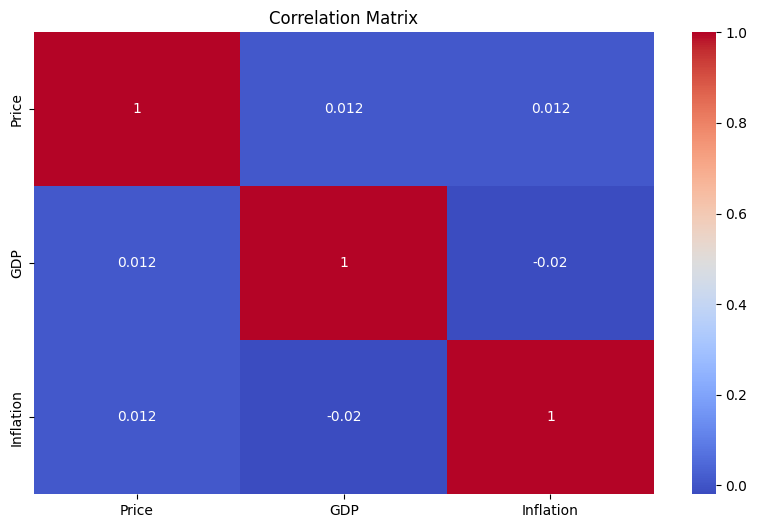

In [9]:
# Exploring the correlation between oil prices and economic indicators
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

4: Model Evaluation

Evaluate the models using performance metrics such as RMSE, MAE, and R-squared.

In [13]:
# VAR model predictions
var_predictions = model_fit.forecast(model_data_diff.values[-model_fit.k_ar:], steps=10)
var_rmse = np.sqrt(mean_squared_error(var_predictions[:, 0], model_data['Price'].values[-10:]))
var_mae = mean_absolute_error(var_predictions[:, 0], model_data['Price'].values[-10:])


print(f'VAR Model - RMSE: {var_rmse}, MAE: {var_mae}')

# LSTM model predictions

# Prepare the data for prediction
X_test = np.expand_dims(X[-10:], axis=0)  # Adjust the dimensions for the LSTM model

# Make predictions
lstm_predictions = model.predict(X_test)
lstm_predictions = np.squeeze(lstm_predictions)  # Remove single-dimensional entries

lstm_rmse = np.sqrt(mean_squared_error(lstm_predictions, y[-10:]))
lstm_mae = mean_absolute_error(lstm_predictions, y[-10:])

print(f'LSTM Model - RMSE: {lstm_rmse}, MAE: {lstm_mae}')

VAR Model - RMSE: 96.022973074943, MAE: 95.99848827779523


ValueError: operands could not be broadcast together with shapes (9009,3) (1,10,60,1) (9009,3) 

Save the Notebook

In [14]:
# Save the notebook
import os

notebook_name = 'model.ipynb'
os.system(f'jupyter nbconvert --to notebook --execute {notebook_name}')

1